In [1]:
# ============================================================
# STEP 1: BASIC SETUP – PATHS, CLASS LISTS, RANDOM SEED
# ============================================================

import os
import csv
import random
import pandas as pd

# 1) Root folder of your dataset (what you showed in the screenshot)
ROOT = r"D:\Fish Dataset"   # change if your folder is elsewhere

# 2) Define which species are "known" (seen during training)
#    and which are "unknown" (only appear at test time).
#    These MUST match the exact folder names.
KNOWN_CLASSES = [
    "Gilt-Head Bream",
    "Hourse Mackerel",
    "Red Mullet",
    "Red Sea Bream",
    "Striped Red Mullet",
    "Trout",
]

UNKNOWN_CLASSES = [
    "Sea Bass",
    "Black Sea Sprat",
    "Shrimp",
]

# 3) Fix the random seed so that splits are reproducible
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

print("Dataset root:", ROOT)
print("Known classes:", KNOWN_CLASSES)
print("Unknown classes:", UNKNOWN_CLASSES)


Dataset root: D:\Fish Dataset
Known classes: ['Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Striped Red Mullet', 'Trout']
Unknown classes: ['Sea Bass', 'Black Sea Sprat', 'Shrimp']


In [2]:
# ============================================================
# STEP 2: SCAN FOLDERS AND BUILD TRAIN / VAL / TEST CSV FILES
# ============================================================

def iter_images(root_dir):
    """
    Walk through all subfolders of `root_dir` and collect:
        [full_path_to_image, class_name]
    Only files with image extensions are kept.
    """
    # allowed image extensions
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp",
            ".JPG", ".JPEG", ".PNG", ".BMP", ".WEBP"}

    rows = []

    # loop over direct subfolders (each folder = one class)
    for cls in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(class_dir):
            # skip files like train.csv / val.csv / test.csv that are already in ROOT
            continue

        # recursively walk inside the class folder (in case there are subfolders)
        for dirpath, _, files in os.walk(class_dir):
            for fn in files:
                ext = os.path.splitext(fn)[1]
                if ext in exts:
                    full_path = os.path.join(dirpath, fn)
                    rows.append([full_path, cls])

    return rows


# 1) Collect all images and their class names
all_rows = iter_images(ROOT)
print(f"Total images found: {len(all_rows)}")

# 2) Shuffle before splitting
random.shuffle(all_rows)

# 3) Prepare containers for each split
train_rows, val_rows, test_rows = [], [], []

# 4) Split logic:
#    - Known classes: 70% train, 15% val, 15% test
#    - Unknown classes: 0% train, 0% val, 100% test
for path, cls in all_rows:
    if cls in KNOWN_CLASSES:
        r = random.random()
        if r < 0.70:
            train_rows.append([path, cls])
        elif r < 0.85:
            val_rows.append([path, cls])
        else:
            test_rows.append([path, cls])
    elif cls in UNKNOWN_CLASSES:
        # unknown classes only appear in the test set
        test_rows.append([path, cls])
    else:
        # safety check: if some folder name is not in KNOWN or UNKNOWN, warn about it
        print("WARNING: class not in KNOWN or UNKNOWN:", cls)


def save_csv(name, data):
    """
    Save a list of [filepath, label] rows as ROOT/name.csv
    with a header: filepath,label
    """
    out_path = os.path.join(ROOT, f"{name}.csv")
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filepath", "label"])
        writer.writerows(data)
    print(f"Saved {out_path} with {len(data)} rows")


# 5) Write the three CSV files
save_csv("train", train_rows)
save_csv("val",   val_rows)
save_csv("test",  test_rows)


Total images found: 9000
Saved D:\Fish Dataset\train.csv with 4173 rows
Saved D:\Fish Dataset\val.csv with 918 rows
Saved D:\Fish Dataset\test.csv with 3909 rows


In [3]:
# ============================================================
# STEP 3: QUICK CHECK – HOW MANY IMAGES PER CLASS IN EACH SPLIT?
# ============================================================

for split_name in ["train", "val", "test"]:
    csv_path = os.path.join(ROOT, f"{split_name}.csv")
    df = pd.read_csv(csv_path)
    print(f"\n=== {split_name.upper()} ({len(df)} samples) ===")
    print(df["label"].value_counts())



=== TRAIN (4173 samples) ===
label
Gilt-Head Bream       709
Red Sea Bream         706
Striped Red Mullet    700
Trout                 694
Red Mullet            683
Hourse Mackerel       681
Name: count, dtype: int64

=== VAL (918 samples) ===
label
Red Mullet            161
Striped Red Mullet    158
Hourse Mackerel       156
Red Sea Bream         153
Trout                 147
Gilt-Head Bream       143
Name: count, dtype: int64

=== TEST (3909 samples) ===
label
Sea Bass              1000
Black Sea Sprat       1000
Shrimp                1000
Hourse Mackerel        163
Trout                  159
Red Mullet             156
Gilt-Head Bream        148
Striped Red Mullet     142
Red Sea Bream          141
Name: count, dtype: int64


In [4]:
 !pip install open_clip_torch scikit-learn pillow tqdm matplotlib

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 20.4 MB/s  0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 20.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 2.9/2.9 MB 28.1 MB/s  0:00:00

   ---- ----------------------------------- 1/9 [safetensors]
   -------- ------------------------------- 2/9 [regex]
   ----------------- ---------------------- 4/9 [ftfy]
   ---------------------- ----------------- 5/9 [typer-slim]
   -------------------------- ------------- 6/9 [huggingface-hub]
   -------------------------- ------------- 6/9 [huggingface-hub]
   -------------------------- ------------- 6/9 [huggingface-hub]
   -------------------------- ------------- 6/9 [huggingface-hub]
   -------------------------- ------------- 6/9 [huggingface-hub]
   ---

In [5]:
# ============================================================
# STEP 4A: CLOSED-SET BASELINE – SETUP CLIP + DATASET
# ============================================================

# NOTE:
# Make sure these are installed in your environment:
#   pip install open_clip_torch scikit-learn pillow tqdm matplotlib

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import open_clip
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reuse ROOT from previous cells
csv_train = os.path.join(ROOT, "train.csv")
csv_val   = os.path.join(ROOT, "val.csv")
csv_test  = os.path.join(ROOT, "test.csv")

# ------------------------------------------------------------
# 1) Choose device: GPU if available, else CPU
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ------------------------------------------------------------
# 2) Small helper Dataset that reads from our CSV files
# ------------------------------------------------------------
class FishCSV(Dataset):
    """
    Simple dataset:
      - reads a CSV with columns [filepath, label]
      - loads each image
      - applies CLIP's preprocessing
      - returns (image_tensor, label_string)
    """
    def __init__(self, csv_path, preprocess):
        self.df = pd.read_csv(csv_path)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        label    = row["label"]

        # load image with PIL and ensure RGB
        img = Image.open(img_path).convert("RGB")

        # apply CLIP preprocessing (resize, center crop, normalize, etc.)
        img_tensor = self.preprocess(img)

        return img_tensor, label

# ------------------------------------------------------------
# 3) Load a CLIP model and its preprocessing
#    We try a large model first (ViT-L/14), then fall back if needed.
# ------------------------------------------------------------
def load_clip_backbone(device="cuda"):
    for name in ["ViT-L-14", "ViT-B-16", "ViT-B-32"]:
        try:
            model, _, preprocess = open_clip.create_model_and_transforms(
                name, pretrained="openai"
            )
            model.eval().to(device)
            print(f"Loaded CLIP backbone: {name}")
            return model, preprocess, name
        except RuntimeError as e:
            print(f"Could not load {name} on this device: {e}")
    raise RuntimeError("No CLIP model could be loaded.")

clip_model, clip_preprocess, clip_name = load_clip_backbone(device)

# ------------------------------------------------------------
# 4) Create dataset objects for train/val/test
# ------------------------------------------------------------
train_ds = FishCSV(csv_train, clip_preprocess)
val_ds   = FishCSV(csv_val,   clip_preprocess)
test_ds  = FishCSV(csv_test,  clip_preprocess)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples:   {len(val_ds)}")
print(f"Test samples:  {len(test_ds)}")


Using device: cuda


D:\ananconda\envs\fathomnet-eda\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Loaded CLIP backbone: ViT-L-14
Train samples: 4173
Val samples:   918
Test samples:  3909


In [6]:
# ============================================================
# STEP 4B: EXTRACT CLIP FEATURES + TRAIN LINEAR CLASSIFIER
# ============================================================

@torch.no_grad()
def extract_features(dataset, batch_size=32):
    """
    Convert a whole dataset into:
      - features: numpy array of shape [N, D]
      - labels:   numpy array of strings shape [N]
    Steps:
      1) Loop over data in mini-batches
      2) Move images to GPU/CPU
      3) Encode with CLIP -> feature vectors
      4) L2-normalize features (helps distance-based methods later)
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_feats = []
    all_labels = []

    for imgs, labels in tqdm(loader, desc="Extracting CLIP features"):
        imgs = imgs.to(device)
        # Encode images into CLIP embedding space
        feats = clip_model.encode_image(imgs)
        # L2-normalize along feature dimension
        feats = feats / feats.norm(dim=-1, keepdim=True)

        all_feats.append(feats.cpu().numpy())
        all_labels.extend(labels)

    # stack into big arrays
    feats = np.concatenate(all_feats, axis=0)
    labels = np.array(all_labels)
    return feats, labels


# 1) Extract features for train / val / test
F_train, y_train = extract_features(train_ds, batch_size=32)
F_val,   y_val   = extract_features(val_ds,   batch_size=32)
F_test,  y_test  = extract_features(test_ds,  batch_size=32)

print("Feature shapes:")
print("  train:", F_train.shape, "| labels:", y_train.shape)
print("  val:  ", F_val.shape,   "| labels:", y_val.shape)
print("  test: ", F_test.shape,  "| labels:", y_test.shape)

# 2) Train a linear classifier (Logistic Regression) on CLIP features
clf = LogisticRegression(
    max_iter=4000,        # allow enough iterations for convergence
    multi_class="multinomial",
    n_jobs=None           # use all cores; set to 1 if you get issues
)
clf.fit(F_train, y_train)

# 3) Closed-set accuracy: assume all classes are known
val_pred = clf.predict(F_val)
test_pred = clf.predict(F_test)

val_acc  = accuracy_score(y_val,  val_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"\n[{clip_name}] Closed-set validation accuracy: {val_acc*100:.2f}%")
print(f"[{clip_name}] Closed-set test accuracy (all classes treated as known): {test_acc*100:.2f}%")


Extracting CLIP features: 100%|██████████| 123/123 [08:20<00:00,  4.07s/it]
D:\ananconda\envs\fathomnet-eda\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature shapes:
  train: (4173, 768) | labels: (4173,)
  val:   (918, 768) | labels: (918,)
  test:  (3909, 768) | labels: (3909,)

[ViT-L-14] Closed-set validation accuracy: 99.78%
[ViT-L-14] Closed-set test accuracy (all classes treated as known): 23.23%


In [7]:
# ============================================================
# STEP 5A: COMPUTE OSR SCORES (MSP, ENERGY, MAHALANOBIS)
# ============================================================

from sklearn.metrics import roc_auc_score
from sklearn.covariance import LedoitWolf
import torch

# ------------------------------------------------------------
# 1) Identify which labels are known in the test set
# ------------------------------------------------------------
known_classes = KNOWN_CLASSES
is_known = np.isin(y_test, known_classes).astype(int)   # 1=known, 0=unknown

print("Known test samples :", is_known.sum())
print("Unknown test samples :", (1 - is_known).sum())

# ------------------------------------------------------------
# 2) MSP (max softmax probability)
# ------------------------------------------------------------
probs_test = clf.predict_proba(F_test)
msp_scores = probs_test.max(axis=1)

# ------------------------------------------------------------
# 3) Energy score (logsumexp of logits)
# ------------------------------------------------------------
logits_test = clf.decision_function(F_test)
logits_test = logits_test / 1.5   # temperature scaling
energy_scores = torch.logsumexp(torch.tensor(logits_test), dim=1).numpy()

# ------------------------------------------------------------
# 4) Mahalanobis distance in CLIP feature space
# ------------------------------------------------------------

# map labels to integer IDs
lab2id = {cls: i for i, cls in enumerate(known_classes)}
y_train_ids = np.array([lab2id[label] for label in y_train])

# compute per-class means
means = np.stack([
    F_train[y_train_ids == i].mean(axis=0)
    for i in range(len(known_classes))
])

# use LedoitWolf for stable covariance
cov = LedoitWolf().fit(F_train)
inv_cov = cov.precision_

# mahalanobis score function
def maha_score(x):
    dists = [np.sqrt((x - m) @ inv_cov @ (x - m)) for m in means]
    return -min(dists)  # higher = more likely known

maha_scores = np.array([maha_score(f) for f in F_test])

print("Done computing scores.")


Known test samples : 909
Unknown test samples : 3000
Done computing scores.


AUROC (MSP)            : 0.882
AUROC (Energy)         : 0.864
AUROC (Mahalanobis)    : 0.992


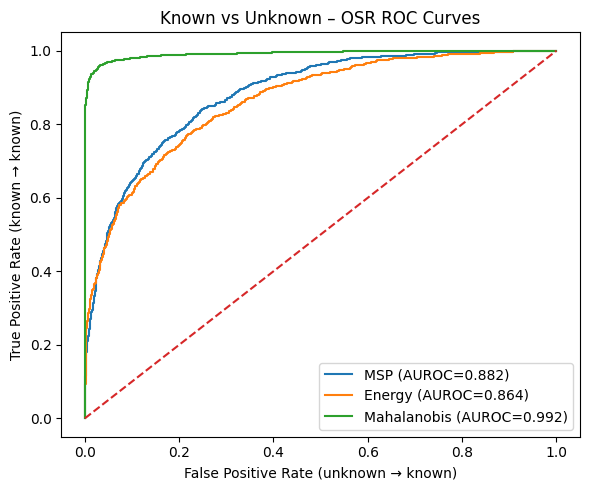

In [8]:
# ============================================================
# STEP 5B: EVALUATE OSR – AUROC FOR MSP / ENERGY / MAHALANOBIS
# ============================================================

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# y_true for AUROC: 1 = known sample, 0 = unknown sample
y_true = is_known  # already 0/1 from previous cell

# 1) AUROC for MSP (max softmax probability)
auroc_msp = roc_auc_score(y_true, msp_scores)
print(f"AUROC (MSP)            : {auroc_msp:.3f}")

# 2) AUROC for Energy score
auroc_energy = roc_auc_score(y_true, energy_scores)
print(f"AUROC (Energy)         : {auroc_energy:.3f}")

# 3) AUROC for Mahalanobis score
auroc_maha = roc_auc_score(y_true, maha_scores)
print(f"AUROC (Mahalanobis)    : {auroc_maha:.3f}")

# ------------------------------------------------------------
# (Optional but nice) – plot ROC curves to compare visually
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))

for name, scores in [
    (f"MSP (AUROC={auroc_msp:.3f})", msp_scores),
    (f"Energy (AUROC={auroc_energy:.3f})", energy_scores),
    (f"Mahalanobis (AUROC={auroc_maha:.3f})", maha_scores),
]:
    fpr, tpr, _ = roc_curve(y_true, scores)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], "--")  # random baseline
plt.xlabel("False Positive Rate (unknown → known)")
plt.ylabel("True Positive Rate (known → known)")
plt.title("Known vs Unknown – OSR ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# STEP 5C: THRESHOLD SELECTION + OSR PREDICTIONS
# ============================================================

from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# ------------------------------------------------------------
# 1) Pick threshold from known samples only
#    We want the model to accept 95% of known images.
# ------------------------------------------------------------

known_scores = maha_scores[is_known == 1]

# Threshold = 5th percentile of known scores
threshold = np.percentile(known_scores, 5)

print(f"Mahalanobis threshold (5th percentile): {threshold:.4f}")

# ------------------------------------------------------------
# 2) Predict known vs unknown using threshold
# ------------------------------------------------------------
pred_is_known = (maha_scores >= threshold).astype(int)  # 1=known, 0=unknown

# ------------------------------------------------------------
# 3) For samples predicted as known, assign closed-set class label
# ------------------------------------------------------------
test_pred_closed = clf.predict(F_test)

# OSR final predictions:
#   class name for known samples
#   "UNKNOWN" for unknown samples
y_pred_osr = np.array([
    cls if k == 1 else "UNKNOWN"
    for cls, k in zip(test_pred_closed, pred_is_known)
])

# ------------------------------------------------------------
# 4) Evaluate OSR performance
# ------------------------------------------------------------

# Confusion matrix for known vs unknown decision
cm = confusion_matrix(is_known, pred_is_known, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix (rows=true [unknown, known], cols=pred [unknown, known]):")
print(cm)

tnr = tn / (tn + fp + 1e-9)  # reject unknowns
tpr = tp / (tp + fn + 1e-9)  # accept knowns

print(f"\nTNR (unknown correctly rejected) : {tnr:.3f}")
print(f"TPR (known correctly accepted)   : {tpr:.3f}")

# ------------------------------------------------------------
# 5) Accuracy on known samples that the model accepted
# ------------------------------------------------------------
mask_correct_known = (is_known == 1) & (pred_is_known == 1)

if mask_correct_known.sum() > 0:
    acc_known_cond = accuracy_score(
        y_test[mask_correct_known],
        y_pred_osr[mask_correct_known]
    )
    print(f"\nAccuracy on accepted known samples: {acc_known_cond*100:.2f}%")
else:
    print("\nNo known samples were accepted using this threshold.")

# ------------------------------------------------------------
# 6) Quick view of predicted distribution
# ------------------------------------------------------------
from collections import Counter

print("\nPrediction distribution:")
print(Counter(y_pred_osr))


Mahalanobis threshold (5th percentile): -32.0566

Confusion Matrix (rows=true [unknown, known], cols=pred [unknown, known]):
[[2924   76]
 [  46  863]]

TNR (unknown correctly rejected) : 0.975
TPR (known correctly accepted)   : 0.949

Accuracy on accepted known samples: 99.88%

Prediction distribution:
Counter({np.str_('UNKNOWN'): 2970, np.str_('Gilt-Head Bream'): 211, np.str_('Hourse Mackerel'): 163, np.str_('Trout'): 155, np.str_('Red Sea Bream'): 139, np.str_('Red Mullet'): 136, np.str_('Striped Red Mullet'): 135})


In [10]:
# ============================================================
# STEP 6A: BUILD INDEX GROUPS FOR VISUALISATION
# ============================================================
import numpy as np

# Indices of all test samples
idx_all = np.arange(len(y_test))

# True / predicted known-unknown flags (we already have is_known, pred_is_known)
true_known      = (is_known == 1)
true_unknown    = (is_known == 0)
pred_known_flag = (pred_is_known == 1)
pred_unknown_flag = (pred_is_known == 0)

# 1) Correctly rejected unknowns: true unknown AND predicted unknown
idx_correct_reject = idx_all[true_unknown & pred_unknown_flag]

# 2) Unknowns mistakenly accepted as known
idx_unknown_accepted = idx_all[true_unknown & pred_known_flag]

# 3) Known samples correctly accepted
idx_known_accepted = idx_all[true_known & pred_known_flag]

# 4) Known samples mistakenly rejected
idx_known_rejected = idx_all[true_known & pred_unknown_flag]

print("Correctly rejected unknowns :", len(idx_correct_reject))
print("Unknown accepted as known   :", len(idx_unknown_accepted))
print("Known correctly accepted    :", len(idx_known_accepted))
print("Known rejected as unknown   :", len(idx_known_rejected))


Correctly rejected unknowns : 2924
Unknown accepted as known   : 76
Known correctly accepted    : 863
Known rejected as unknown   : 46


In [11]:
# ============================================================
# STEP 6B: VISUALISE RANDOM EXAMPLES FROM ANY GROUP
# ============================================================
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(0)  # for reproducible sampling


def show_examples(idxs, title, max_images=9):
    """
    Visualise up to `max_images` test samples indexed by `idxs`.
    For each image we show:
      - True label
      - OSR prediction (class or 'UNKNOWN')
      - Mahalanobis score
    """
    if len(idxs) == 0:
        print(f"No samples to show for: {title}")
        return

    # select up to max_images random indices
    chosen = random.sample(list(idxs), k=min(max_images, len(idxs)))

    n = len(chosen)
    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(title, fontsize=16)

    for i, idx in enumerate(chosen, 1):
        row = test_ds.df.iloc[idx]
        img_path = row["filepath"]
        true_label = row["label"]
        pred_label = y_pred_osr[idx]
        score = maha_scores[idx]

        img = Image.open(img_path).convert("RGB")

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"T: {true_label}\nP: {pred_label}\nscore: {score:.1f}",
            fontsize=10
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Showing correctly rejected unknown species...


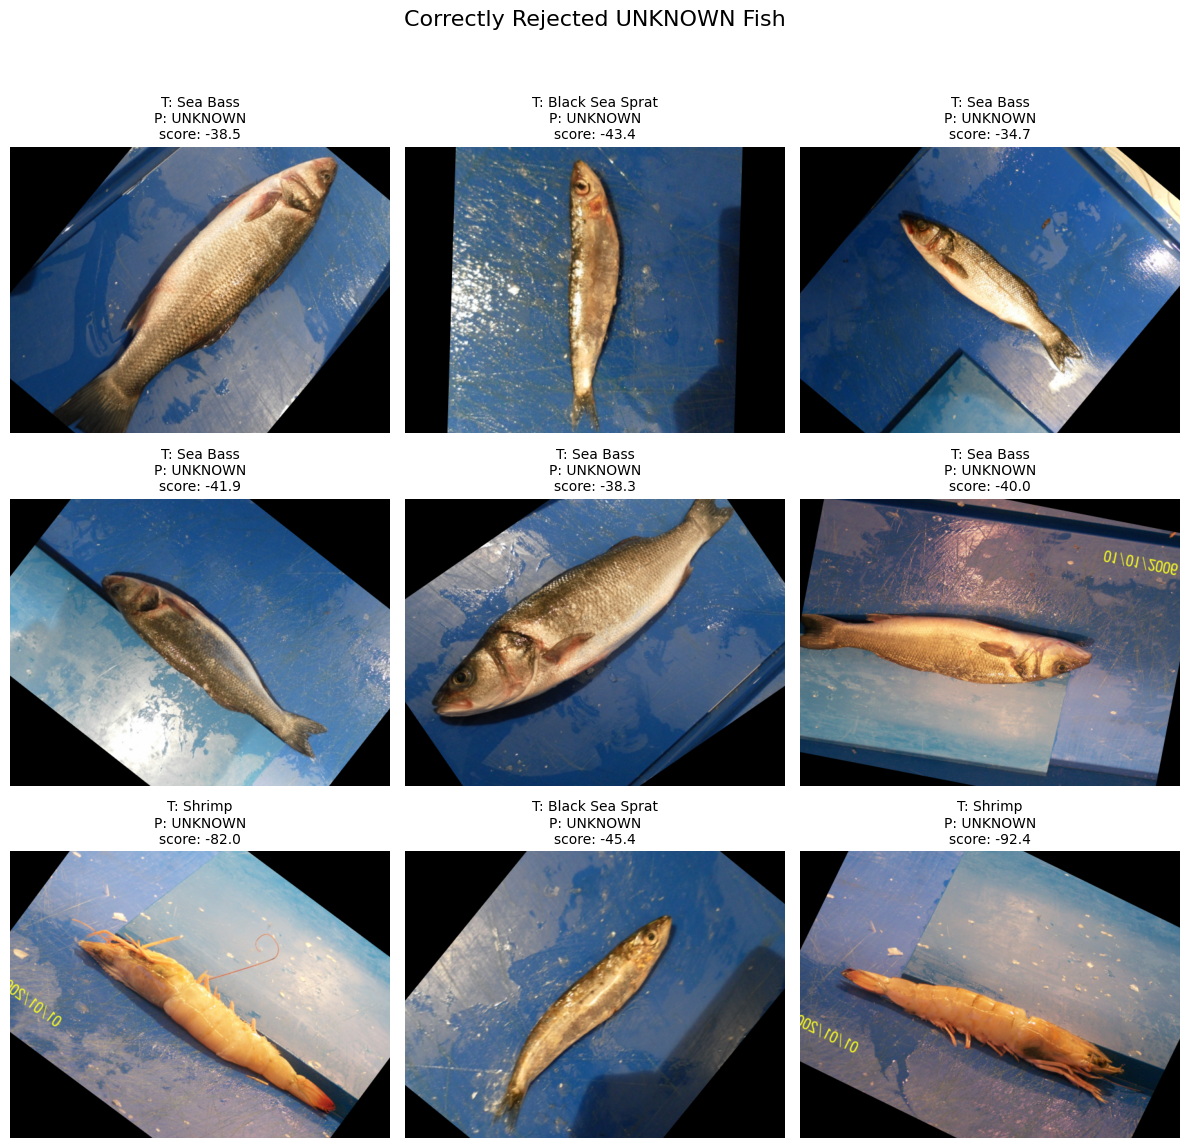

Showing correctly accepted known species...


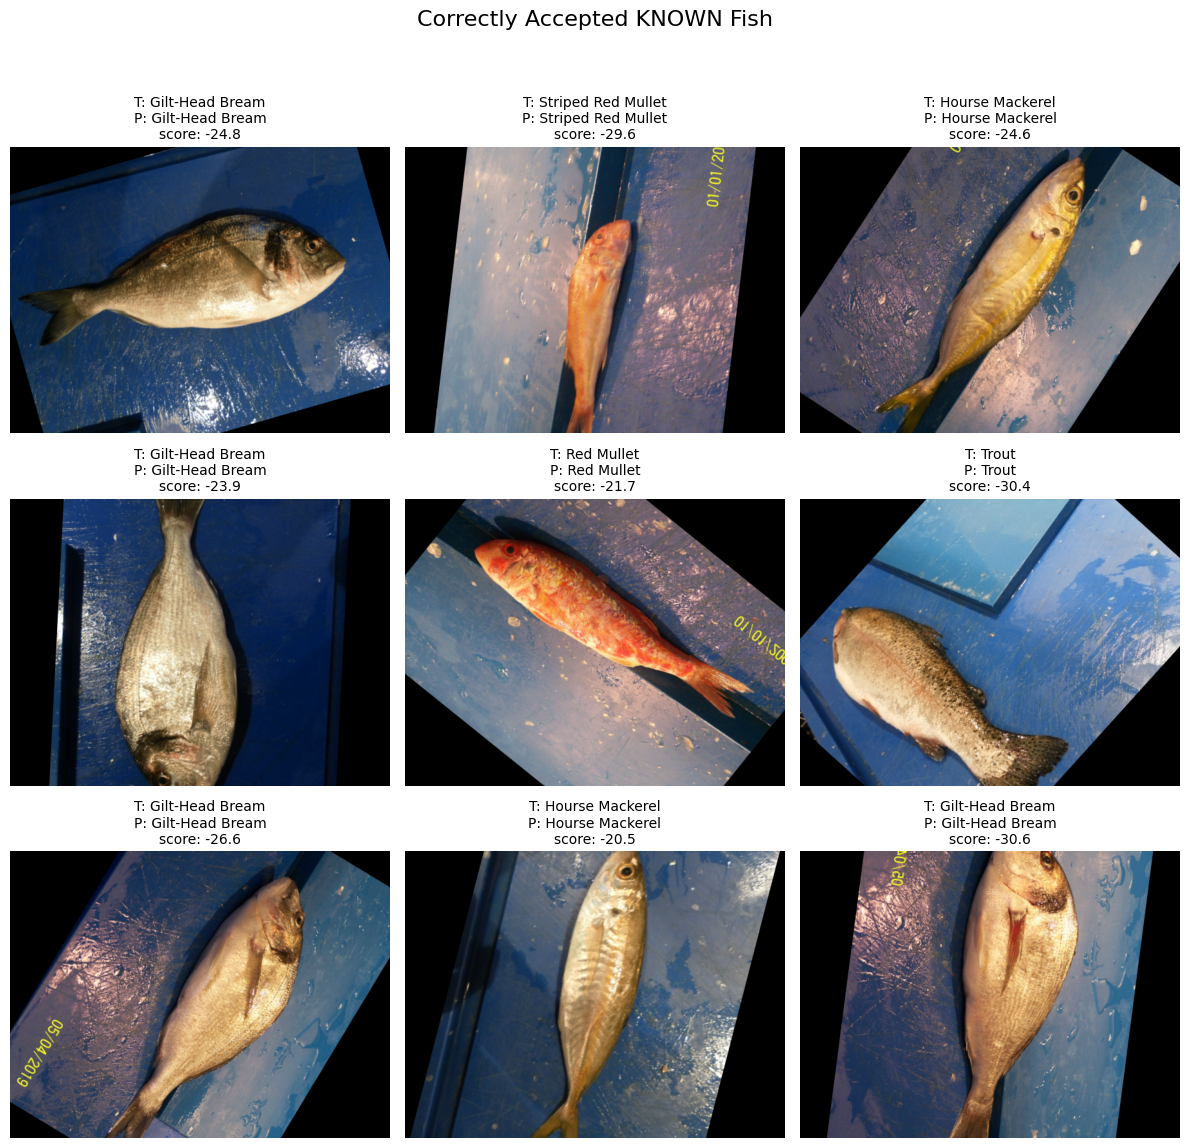

Showing misclassified unknown species...


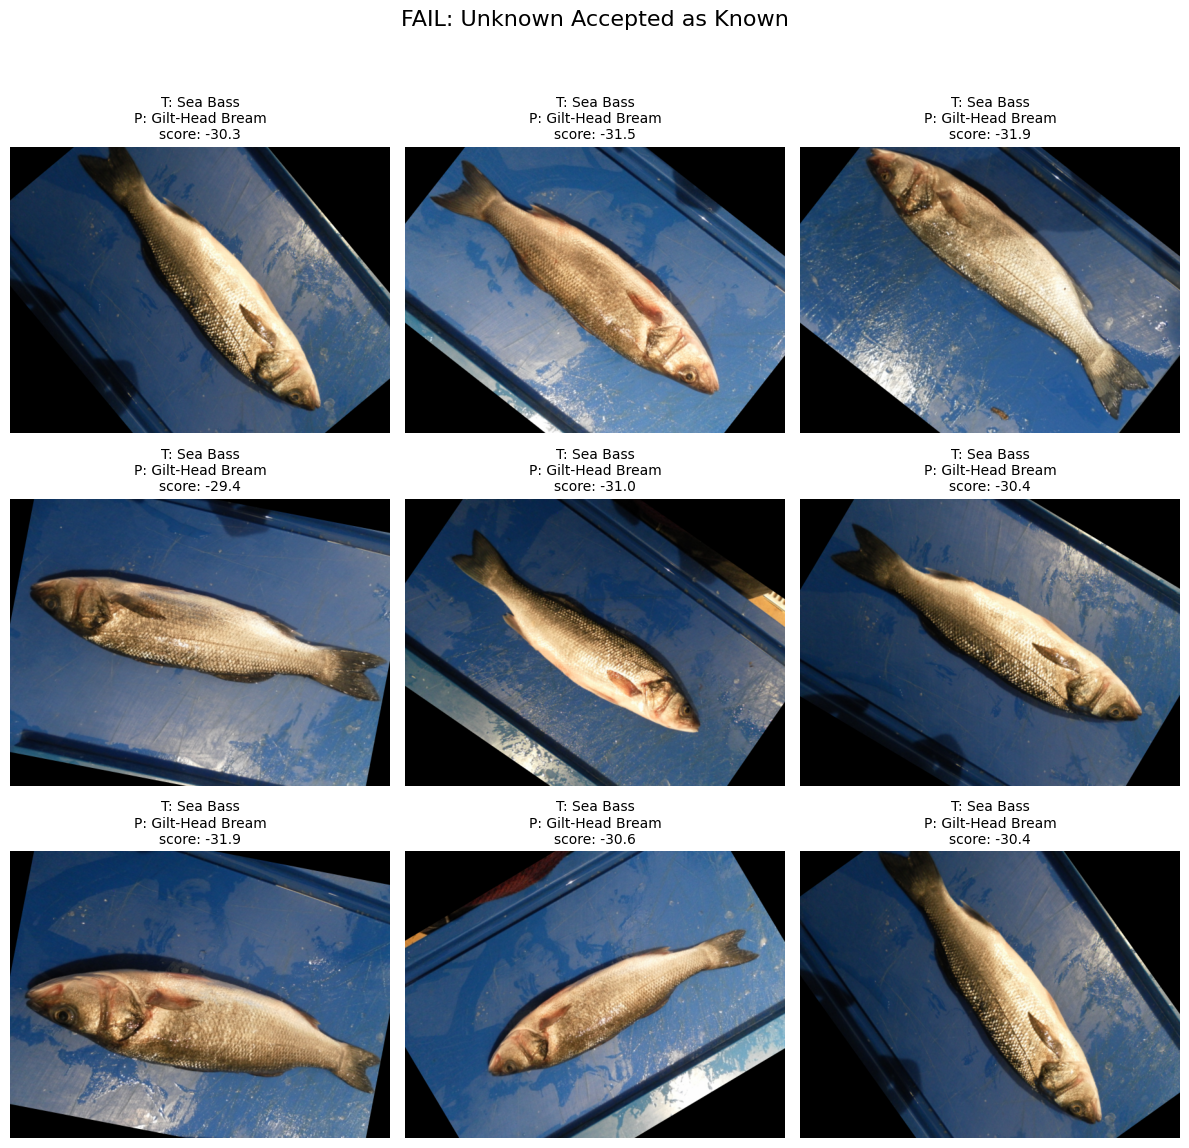

Showing known species rejected as unknown...


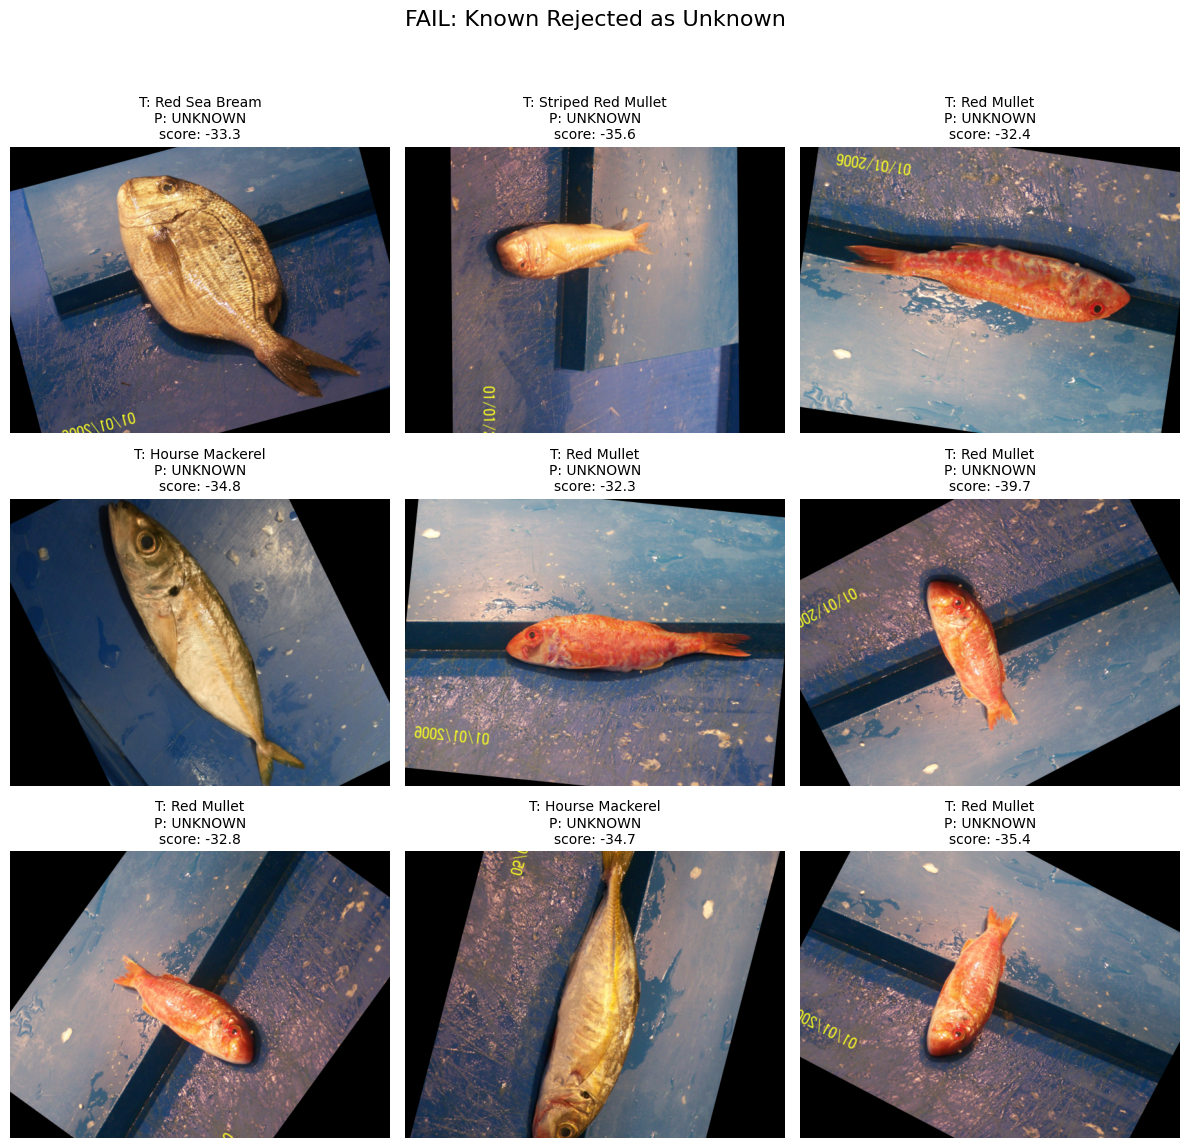

In [12]:
# ============================================================
# STEP 6C: RUN VISUALIZATIONS
# ============================================================

print("Showing correctly rejected unknown species...")
show_examples(idx_correct_reject, "Correctly Rejected UNKNOWN Fish")

print("Showing correctly accepted known species...")
show_examples(idx_known_accepted, "Correctly Accepted KNOWN Fish")

print("Showing misclassified unknown species...")
show_examples(idx_unknown_accepted, "FAIL: Unknown Accepted as Known")

print("Showing known species rejected as unknown...")
show_examples(idx_known_rejected, "FAIL: Known Rejected as Unknown")


In [13]:
# ============================================================
# STEP 7A: DEFINE A FUNCTION TO EVALUATE ONE CLIP BACKBONE
# ============================================================

import time
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score

def run_clip_osr_experiment(backbone_name, device="cuda"):
    """
    Run the full pipeline for a given CLIP backbone:
      1) Load CLIP model + preprocess
      2) Build FishCSV datasets
      3) Extract features (train/val/test)
      4) Train Logistic Regression on train features
      5) Evaluate:
           - val accuracy
           - closed-set test accuracy on KNOWN classes only
           - AUROC for MSP, Energy, Mahalanobis
    Returns:
      A dict of metrics for easy comparison.
    """
    print("\n" + "="*60)
    print(f"Running experiment for backbone: {backbone_name}")
    print("="*60)

    # -------------------------------
    # 1) Load CLIP model
    # -------------------------------
    try:
        model, _, preprocess = open_clip.create_model_and_transforms(
            backbone_name, pretrained="openai"
        )
    except RuntimeError as e:
        print(f"Could not load {backbone_name}: {e}")
        return None

    model.eval().to(device)

    # -------------------------------
    # 2) Build datasets (new preprocess)
    # -------------------------------
    ds_train = FishCSV(csv_train, preprocess)
    ds_val   = FishCSV(csv_val,   preprocess)
    ds_test  = FishCSV(csv_test,  preprocess)

    print(f"Train/Val/Test sizes: {len(ds_train)}, {len(ds_val)}, {len(ds_test)}")

    # -------------------------------
    # 3) Feature extraction
    # -------------------------------
    @torch.no_grad()
    def extract_features_local(dataset, batch_size=32):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        all_feats, all_labels = [], []
        for imgs, labels in tqdm(loader, desc=f"Features ({backbone_name})"):
            imgs = imgs.to(device)
            feats = model.encode_image(imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            all_feats.append(feats.cpu().numpy())
            all_labels.extend(labels)
        feats = np.concatenate(all_feats, axis=0)
        labels = np.array(all_labels)
        return feats, labels

    t0 = time.time()
    F_tr, y_tr = extract_features_local(ds_train)
    F_va, y_va = extract_features_local(ds_val)
    F_te, y_te = extract_features_local(ds_test)
    t1 = time.time()
    print(f"Feature extraction time: {t1 - t0:.1f} seconds")
    print("Feature dimensions:", F_tr.shape[1])

    # -------------------------------
    # 4) Train Logistic Regression
    # -------------------------------
    clf_local = LogisticRegression(
        max_iter=4000,
        multi_class="multinomial",
        n_jobs=None
    )
    clf_local.fit(F_tr, y_tr)

    va_pred = clf_local.predict(F_va)
    val_acc = accuracy_score(y_va, va_pred)

    # Closed-set test accuracy on KNOWN classes only
    is_known_te = np.isin(y_te, KNOWN_CLASSES)
    te_pred = clf_local.predict(F_te[is_known_te])
    test_closed_known_acc = accuracy_score(y_te[is_known_te], te_pred)

    print(f"Val accuracy (closed-set):       {val_acc*100:.2f}%")
    print(f"Test acc (known classes only):   {test_closed_known_acc*100:.2f}%")

    # -------------------------------
    # 5) OSR scores: MSP / Energy / Mahalanobis
    # -------------------------------
    # MSP
    probs_te = clf_local.predict_proba(F_te)
    msp_scores_local = probs_te.max(axis=1)

    # Energy
    logits_te = clf_local.decision_function(F_te) / 1.5
    energy_scores_local = torch.logsumexp(
        torch.tensor(logits_te), dim=1
    ).numpy()

    # Mahalanobis
    lab2id = {c: i for i, c in enumerate(KNOWN_CLASSES)}
    y_tr_ids = np.array([lab2id[label] for label in y_tr])

    means_local = np.stack([
        F_tr[y_tr_ids == i].mean(axis=0)
        for i in range(len(KNOWN_CLASSES))
    ])

    cov_local = LedoitWolf().fit(F_tr)
    inv_cov_local = cov_local.precision_

    def maha_score_local(x):
        dists = [np.sqrt((x - m) @ inv_cov_local @ (x - m)) for m in means_local]
        return -min(dists)

    maha_scores_local = np.array([maha_score_local(f) for f in F_te])

    # AUROC (1 = known, 0 = unknown)
    is_known_flag = np.isin(y_te, KNOWN_CLASSES).astype(int)
    auroc_msp     = roc_auc_score(is_known_flag, msp_scores_local)
    auroc_energy  = roc_auc_score(is_known_flag, energy_scores_local)
    auroc_maha    = roc_auc_score(is_known_flag, maha_scores_local)

    print(f"AUROC (MSP):          {auroc_msp:.3f}")
    print(f"AUROC (Energy):       {auroc_energy:.3f}")
    print(f"AUROC (Mahalanobis):  {auroc_maha:.3f}")

    # Pack everything in a dict so we can compare later
    result = {
        "backbone": backbone_name,
        "feat_dim": F_tr.shape[1],
        "val_acc": val_acc,
        "test_closed_known_acc": test_closed_known_acc,
        "auroc_msp": auroc_msp,
        "auroc_energy": auroc_energy,
        "auroc_maha": auroc_maha,
    }
    return result


In [14]:
# ============================================================
# STEP 7B: RUN MULTIPLE BACKBONES AND COMPARE RESULTS
# ============================================================

import pandas as pd

backbones_to_test = ["ViT-B-32", "ViT-B-16", "ViT-L-14"]

all_results = []

for name in backbones_to_test:
    res = run_clip_osr_experiment(name, device=device)
    if res is not None:
        all_results.append(res)

# Convert to DataFrame for a clean comparison
df_results = pd.DataFrame(all_results)

# Sort by Mahalanobis AUROC (best OSR at the top)
df_results = df_results.sort_values("auroc_maha", ascending=False)

# Display with rounded values for readability
df_display = df_results.copy()
for col in ["val_acc", "test_closed_known_acc", "auroc_msp", "auroc_energy", "auroc_maha"]:
    df_display[col] = (df_display[col] * 100).map(lambda x: f"{x:.2f}%")

df_display



Running experiment for backbone: ViT-B-32


D:\ananconda\envs\fathomnet-eda\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Train/Val/Test sizes: 4173, 918, 3909


Features (ViT-B-32): 100%|██████████| 123/123 [01:00<00:00,  2.05it/s]
D:\ananconda\envs\fathomnet-eda\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 131.3 seconds
Feature dimensions: 512
Val accuracy (closed-set):       99.56%
Test acc (known classes only):   99.34%
AUROC (MSP):          0.813
AUROC (Energy):       0.786
AUROC (Mahalanobis):  0.922

Running experiment for backbone: ViT-B-16


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

D:\ananconda\envs\fathomnet-eda\lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asus\.cache\huggingface\hub\models--timm--vit_base_patch16_clip_224.openai. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
D:\ananconda\envs\fathomnet-eda\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU m

Train/Val/Test sizes: 4173, 918, 3909


Features (ViT-B-16): 100%|██████████| 123/123 [01:16<00:00,  1.60it/s]
D:\ananconda\envs\fathomnet-eda\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 171.5 seconds
Feature dimensions: 512
Val accuracy (closed-set):       99.78%
Test acc (known classes only):   99.89%
AUROC (MSP):          0.902
AUROC (Energy):       0.905
AUROC (Mahalanobis):  0.962

Running experiment for backbone: ViT-L-14


D:\ananconda\envs\fathomnet-eda\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Train/Val/Test sizes: 4173, 918, 3909


Features (ViT-L-14): 100%|██████████| 123/123 [07:55<00:00,  3.87s/it]
D:\ananconda\envs\fathomnet-eda\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 1264.8 seconds
Feature dimensions: 768
Val accuracy (closed-set):       99.78%
Test acc (known classes only):   99.89%
AUROC (MSP):          0.882
AUROC (Energy):       0.864
AUROC (Mahalanobis):  0.992


backbone  feat_dim val_acc test_closed_known_acc auroc_msp auroc_energy  \
2  ViT-L-14       768  99.78%                99.89%    88.21%       86.39%   
1  ViT-B-16       512  99.78%                99.89%    90.17%       90.47%   
0  ViT-B-32       512  99.56%                99.34%    81.27%       78.60%   

  auroc_maha  
2     99.20%  
1     96.25%  
0     92.17%

In [15]:
#Advanced OCR Models

In [16]:
# ============================================================
# STEP 8A: BUILD A COSINE CLASSIFIER (CLASS PROTOTYPES)
# ============================================================

import numpy as np
import torch

# 1) Map class label -> integer id  (reuse same mapping as before)
cls2id = {c: i for i, c in enumerate(KNOWN_CLASSES)}
id2cls = {i: c for c, i in cls2id.items()}

# 2) Convert labels of TRAIN set to integer ids
y_train_ids = np.array([cls2id[label] for label in y_train])

num_classes = len(KNOWN_CLASSES)
feat_dim    = F_train.shape[1]
print("Num classes:", num_classes, "| Feature dim:", feat_dim)

# 3) Compute per-class prototypes in feature space
#    Each prototype = mean of features of that class, then L2-normalised.
prototypes = np.zeros((num_classes, feat_dim), dtype=np.float32)

for cid in range(num_classes):
    class_feats = F_train[y_train_ids == cid]
    proto = class_feats.mean(axis=0)
    proto = proto / np.linalg.norm(proto)   # L2 normalise
    prototypes[cid] = proto

print("Prototypes shape:", prototypes.shape)

# 4) Convert prototypes to a torch tensor on the same device
prototypes_t = torch.from_numpy(prototypes).to(device)   # [C, D]

# We'll use a temperature / scale factor for logits
COSINE_SCALE = 20.0  # typical values: 10–30
print("Cosine classifier scale:", COSINE_SCALE)


Num classes: 6 | Feature dim: 768
Prototypes shape: (6, 768)
Cosine classifier scale: 20.0


In [17]:
# ============================================================
# STEP 8B: EVALUATE COSINE CLASSIFIER (CLOSED-SET + OSR)
# ============================================================

from sklearn.metrics import accuracy_score, roc_auc_score

def cosine_head_predict(F, scale=COSINE_SCALE):
    """
    F: numpy array of shape [N, D] with L2-normalised features.
    Returns:
      - predicted class labels (strings)
      - MSP scores (max softmax prob)
      - Energy scores (logsumexp of logits)
    """
    # convert features to torch
    feats = torch.from_numpy(F).to(device)        # [N, D]

    # cosine similarity = dot product because both are L2-normalised
    # logits: [N, C] = scale * (feats @ prototypes^T)
    logits = scale * (feats @ prototypes_t.T)     # [N, C]

    # softmax over classes
    probs = torch.softmax(logits, dim=1)          # [N, C]

    # MSP = max softmax probability
    msp = probs.max(dim=1).values.cpu().numpy()

    # Energy = logsumexp(logits)
    energy = torch.logsumexp(logits, dim=1).cpu().numpy()

    # predicted class ids
    pred_ids = probs.argmax(dim=1).cpu().numpy()
    pred_labels = np.array([id2cls[i] for i in pred_ids])

    return pred_labels, msp, energy


# -----------------------
# 1) Closed-set accuracy
# -----------------------
val_pred_cos, val_msp_cos, val_energy_cos = cosine_head_predict(F_val)
test_pred_cos, test_msp_cos, test_energy_cos = cosine_head_predict(F_test)

val_acc_cos = accuracy_score(y_val, val_pred_cos)

# closed-set accuracy on KNOWN test only
mask_known_test = np.isin(y_test, KNOWN_CLASSES)
test_acc_known_cos = accuracy_score(
    y_test[mask_known_test],
    test_pred_cos[mask_known_test]
)

print(f"[Cosine] Val accuracy (closed-set)      : {val_acc_cos*100:.2f}%")
print(f"[Cosine] Test accuracy (known only)    : {test_acc_known_cos*100:.2f}%")

# -----------------------
# 2) OSR AUROC with MSP / Energy
#    (Mahalanobis stays the same – only the head changed)
# -----------------------
# is_known is already 0/1 for test set
auroc_msp_cos    = roc_auc_score(is_known, val_msp_cos := test_msp_cos)   # noqa
auroc_energy_cos = roc_auc_score(is_known, val_energy_cos := test_energy_cos)

print(f"[Cosine] AUROC (MSP)    : {auroc_msp_cos:.3f}")
print(f"[Cosine] AUROC (Energy) : {auroc_energy_cos:.3f}")
print(f"[Cosine] AUROC (Mahalanobis – unchanged): {roc_auc_score(is_known, maha_scores):.3f}")


[Cosine] Val accuracy (closed-set)      : 97.17%
[Cosine] Test accuracy (known only)    : 96.04%
[Cosine] AUROC (MSP)    : 0.860
[Cosine] AUROC (Energy) : 0.891
[Cosine] AUROC (Mahalanobis – unchanged): 0.992


In [18]:
# ============================================================
# STEP 9A: HOOK INTO ViT-L/14 TRANSFORMER BLOCKS
#         AND EXTRACT MULTI-LAYER FEATURES
# ============================================================

import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Make sure we're using the ViT-L/14 model
print(type(clip_model.visual))

# 1) Choose some transformer blocks inside ViT-L/14
#    ViT-L/14 typically has 24 blocks (index 0..23).
#    We'll tap into 4 of them: early, mid1, mid2, late.
LAYER_IDS = [3, 7, 15, 23]
LAYER_NAMES = [f"block_{i}" for i in LAYER_IDS]

print("Using transformer blocks:", LAYER_IDS)

# 2) Dict to store activations during forward pass
deep_activations = {}

def make_hook(name):
    """
    Creates a forward hook that stores the CLS token
    from the output of a transformer block.
    """
    def hook(module, input, output):
        # output shape: [B, tokens, D]
        # CLS token is position 0
        cls_token = output[:, 0, :].detach()
        deep_activations[name] = cls_token
    return hook

# 3) Register hooks on the selected blocks
hooks = []
for block_id, name in zip(LAYER_IDS, LAYER_NAMES):
    block = clip_model.visual.transformer.resblocks[block_id]
    h = block.register_forward_hook(make_hook(name))
    hooks.append(h)

print(f"Registered {len(hooks)} hooks on ViT-L/14.")


@torch.no_grad()
def extract_multilayer_features(dataset, batch_size=32):
    """
    For each image in `dataset`, run the CLIP image encoder once
    and collect CLS-token features from selected transformer blocks.

    Returns:
        feats_dict: dict layer_name -> np.array [N, D]
        labels:     np.array [N] of string labels
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # For each layer, store a list of mini-batch arrays, then concat at the end
    feats_per_layer = {name: [] for name in LAYER_NAMES}
    all_labels = []

    for imgs, labels in tqdm(loader, desc="Deep features"):
        imgs = imgs.to(device)

        # run full CLIP encoder; hooks will fill deep_activations
        _ = clip_model.encode_image(imgs)

        # for each selected layer, grab CLS token from deep_activations
        for name in LAYER_NAMES:
            cls_feats = deep_activations[name]        # [B, D]
            # L2-normalise per sample
            cls_feats = cls_feats / cls_feats.norm(dim=-1, keepdim=True)
            feats_per_layer[name].append(cls_feats.cpu().numpy())

        all_labels.extend(labels)

    # concat along batch dimension
    feats_dict = {
        name: np.concatenate(feats_list, axis=0)
        for name, feats_list in feats_per_layer.items()
    }
    labels = np.array(all_labels)

    # sanity check: each layer should have same N as dataset
    print("Dataset size:", len(dataset))
    for name in LAYER_NAMES:
        print(name, "features:", feats_dict[name].shape)

    return feats_dict, labels


<class 'open_clip.transformer.VisionTransformer'>
Using transformer blocks: [3, 7, 15, 23]
Registered 4 hooks on ViT-L/14.


In [19]:
# ============================================================
# STEP 9B: EXTRACT MULTI-LAYER FEATURES + DEEP MAHALANOBIS OSR
# ============================================================

from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score
import numpy as np

# 1) Extract multi-layer features for TRAIN and TEST
deep_F_train, deep_y_train = extract_multilayer_features(train_ds)
deep_F_test,  deep_y_test  = extract_multilayer_features(test_ds)

# Sanity check: labels should match previous y_train / y_test
print("\nTrain labels same as before? ", np.all(deep_y_train == y_train))
print("Test labels same as before?  ", np.all(deep_y_test  == y_test))

# is_known is already defined for test set (1 = known, 0 = unknown)
y_true_known_flag = is_known.astype(int)


def layer_mahalanobis_scores(F_train_layer, F_test_layer, y_train_labels):
    """
    Compute Mahalanobis scores for one layer:
      - fit mean per class (on training features of known classes)
      - fit LedoitWolf covariance on ALL train features
      - score each test feature: higher score = more likely known
    """
    # map class label -> id for known classes
    lab2id = {c: i for i, c in enumerate(KNOWN_CLASSES)}
    y_ids = np.array([lab2id[label] for label in y_train_labels])

    # per-class mean vectors
    means = np.stack([
        F_train_layer[y_ids == i].mean(axis=0)
        for i in range(len(KNOWN_CLASSES))
    ])

    # covariance + inverse
    cov = LedoitWolf().fit(F_train_layer)
    inv_cov = cov.precision_

    # mahalanobis score: negative distance to nearest class mean
    scores = []
    for f in F_test_layer:
        dists = [np.sqrt((f - m) @ inv_cov @ (f - m)) for m in means]
        scores.append(-min(dists))
    return np.array(scores)


# 2) Compute Mahalanobis AUROC per layer
layer_aurocs = {}
layer_scores = {}

print("\nLayer-wise Mahalanobis AUROC:")
for name in LAYER_NAMES:
    F_tr_l = deep_F_train[name]   # [N_train, D]
    F_te_l = deep_F_test[name]    # [N_test,  D]

    scores_l = layer_mahalanobis_scores(F_tr_l, F_te_l, deep_y_train)
    auroc_l  = roc_auc_score(y_true_known_flag, scores_l)

    layer_scores[name] = scores_l
    layer_aurocs[name] = auroc_l

    print(f"  {name}: AUROC = {auroc_l:.3f}")

# 3) Fuse scores from all selected layers
#    Strategy: min-max normalise each layer's scores to [0,1], then average.
all_scores_mat = []
for name in LAYER_NAMES:
    s = layer_scores[name]
    s_norm = (s - s.min()) / (s.max() - s.min() + 1e-9)
    all_scores_mat.append(s_norm)

all_scores_mat = np.stack(all_scores_mat, axis=1)   # [N_test, num_layers]

# simple average fusion
fused_scores = all_scores_mat.mean(axis=1)
auroc_fused = roc_auc_score(y_true_known_flag, fused_scores)

print(f"\nFused layers (mean of {len(LAYER_NAMES)} layers): AUROC = {auroc_fused:.3f}")


Deep features: 100%|██████████| 131/131 [03:09<00:00,  1.45s/it]


Dataset size: 4173
block_3 features: (4173, 1024)
block_7 features: (4173, 1024)
block_15 features: (4173, 1024)
block_23 features: (4173, 1024)


Deep features: 100%|██████████| 123/123 [05:21<00:00,  2.61s/it]


Dataset size: 3909
block_3 features: (3909, 1024)
block_7 features: (3909, 1024)
block_15 features: (3909, 1024)
block_23 features: (3909, 1024)

Train labels same as before?  True
Test labels same as before?   True

Layer-wise Mahalanobis AUROC:
  block_3: AUROC = 0.825
  block_7: AUROC = 0.986
  block_15: AUROC = 0.963
  block_23: AUROC = 0.992

Fused layers (mean of 4 layers): AUROC = 0.994


In [20]:
# ============================================================
# DEEP MAHALANOBIS FOR ANY CLIP VISION TRANSFORMER BACKBONE
# (ViT-B/32, ViT-B/16, ViT-L/14, etc.)
# ============================================================

import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


def deep_mahalanobis_for_backbone(backbone_name, device="cuda", batch_size=32):
    """
    For a given CLIP ViT backbone:
      1) Load CLIP model + preprocess
      2) Create train/test datasets from csv_train/csv_test
      3) Hook several transformer blocks
      4) Extract multi-layer CLS features
      5) Compute Mahalanobis AUROC per layer and fused

    Returns:
      {
        "backbone": ...,
        "layer_aurocs": dict(layer_name -> AUROC),
        "fused_auroc": float
      }
    """
    print("\n" + "="*70)
    print(f"Deep Mahalanobis for backbone: {backbone_name}")
    print("="*70)

    # 1) Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms(
        backbone_name, pretrained="openai"
    )
    model.eval().to(device)

    # 2) Build datasets for this backbone (new preprocess)
    ds_train = FishCSV(csv_train, preprocess)
    ds_test  = FishCSV(csv_test,  preprocess)

    print(f"Train size: {len(ds_train)} | Test size: {len(ds_test)}")

    # 3) Decide which transformer blocks to tap into
    #    We take ~4 blocks spread across depth.
    num_blocks = len(model.visual.transformer.resblocks)
    print(f"{backbone_name} has {num_blocks} transformer blocks.")

    if num_blocks == 12:
        layer_ids = [2, 5, 8, 11]           # for ViT-B/16, ViT-B/32
    elif num_blocks == 24:
        layer_ids = [3, 7, 15, 23]          # for ViT-L/14 (what you used)
    else:
        # generic: pick quartiles
        layer_ids = sorted(set([
            int(num_blocks * 0.25) - 1,
            int(num_blocks * 0.5)  - 1,
            int(num_blocks * 0.75) - 1,
            num_blocks - 1,
        ]))
    layer_names = [f"block_{i}" for i in layer_ids]
    print("Using blocks:", layer_ids)

    # 4) Register hooks
    deep_acts = {}
    hooks = []

    def make_hook(name):
        def hook(module, input, output):
            # output: [B, tokens, D], CLS token at index 0
            cls_token = output[:, 0, :].detach()
            deep_acts[name] = cls_token
        return hook

    for idx, name in zip(layer_ids, layer_names):
        block = model.visual.transformer.resblocks[idx]
        h = block.register_forward_hook(make_hook(name))
        hooks.append(h)

    print(f"Registered {len(hooks)} hooks.")

    @torch.no_grad()
    def extract_multilayer_feats(dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        feats_per_layer = {name: [] for name in layer_names}
        labels = []

        for imgs, labs in tqdm(loader, desc=f"Deep feats ({backbone_name})"):
            imgs = imgs.to(device)
            _ = model.encode_image(imgs)   # triggers hooks

            for name in layer_names:
                cls_feats = deep_acts[name]                 # [B, D]
                cls_feats = cls_feats / cls_feats.norm(
                    dim=-1, keepdim=True
                )                                           # L2-normalise
                feats_per_layer[name].append(
                    cls_feats.cpu().numpy()
                )

            labels.extend(labs)

        feats_dict = {
            name: np.concatenate(v, axis=0)
            for name, v in feats_per_layer.items()
        }
        labels = np.array(labels)
        return feats_dict, labels

    # 5) Extract deep features for train & test
    deep_F_train, deep_y_train = extract_multilayer_feats(ds_train)
    deep_F_test,  deep_y_test  = extract_multilayer_feats(ds_test)

    print("Train labels aligned with KNOWN/UNKNOWN split? ->",
          np.all(np.isin(deep_y_train, KNOWN_CLASSES)))

    # 6) Mahalanobis per layer
    def layer_maha(F_tr, F_te, y_tr):
        lab2id = {c: i for i, c in enumerate(KNOWN_CLASSES)}
        y_ids = np.array([lab2id[y] for y in y_tr])

        means = np.stack([
            F_tr[y_ids == i].mean(axis=0)
            for i in range(len(KNOWN_CLASSES))
        ])

        cov = LedoitWolf().fit(F_tr)
        inv = cov.precision_

        scores = []
        for f in F_te:
            d = [np.sqrt((f - m) @ inv @ (f - m)) for m in means]
            scores.append(-min(d))  # higher = more likely known
        return np.array(scores)

    # is_known for test set already exists (from your previous code)
    y_true = is_known.astype(int)

    layer_aurocs = {}
    layer_scores = {}

    print("\nLayer-wise Deep Mahalanobis AUROC:")
    for name in layer_names:
        F_tr_l = deep_F_train[name]
        F_te_l = deep_F_test[name]
        s_l = layer_maha(F_tr_l, F_te_l, deep_y_train)
        au_l = roc_auc_score(y_true, s_l)
        layer_scores[name] = s_l
        layer_aurocs[name] = au_l
        print(f"  {name}: {au_l:.3f}")

    # 7) Fuse scores from all layers via normalised averaging
    all_scores = []
    for name in layer_names:
        s = layer_scores[name]
        s_norm = (s - s.min()) / (s.max() - s.min() + 1e-9)
        all_scores.append(s_norm)

    all_scores = np.stack(all_scores, axis=1)          # [N_test, num_layers]
    fused = all_scores.mean(axis=1)
    auroc_fused = roc_auc_score(y_true, fused)

    print(f"\nFused Deep Mahalanobis (mean of {len(layer_names)} layers): AUROC = {auroc_fused:.3f}")

    # 8) Clean up hooks
    for h in hooks:
        h.remove()

    return {
        "backbone": backbone_name,
        "layers": layer_names,
        "layer_aurocs": layer_aurocs,
        "fused_auroc": auroc_fused,
        "fused_scores": fused,
    }


In [21]:
# ============================================================
# RUN DEEP MAHALANOBIS FOR ViT-B/16 AND ViT-B/32
# ============================================================

res_b16 = deep_mahalanobis_for_backbone("ViT-B-16", device=device)
res_b32 = deep_mahalanobis_for_backbone("ViT-B-32", device=device)

print("\nSummary:")
print("ViT-B/16 fused AUROC:", res_b16["fused_auroc"])
print("ViT-B/32 fused AUROC:", res_b32["fused_auroc"])



Deep Mahalanobis for backbone: ViT-B-16


D:\ananconda\envs\fathomnet-eda\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Train size: 4173 | Test size: 3909
ViT-B-16 has 12 transformer blocks.
Using blocks: [2, 5, 8, 11]
Registered 4 hooks.


Deep feats (ViT-B-16): 100%|██████████| 123/123 [01:14<00:00,  1.64it/s]


Train labels aligned with KNOWN/UNKNOWN split? -> True

Layer-wise Deep Mahalanobis AUROC:
  block_2: 0.901
  block_5: 0.984
  block_8: 0.949
  block_11: 0.966

Fused Deep Mahalanobis (mean of 4 layers): AUROC = 0.988

Deep Mahalanobis for backbone: ViT-B-32


D:\ananconda\envs\fathomnet-eda\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Train size: 4173 | Test size: 3909
ViT-B-32 has 12 transformer blocks.
Using blocks: [2, 5, 8, 11]
Registered 4 hooks.


Deep feats (ViT-B-32): 100%|██████████| 123/123 [00:59<00:00,  2.07it/s]


Train labels aligned with KNOWN/UNKNOWN split? -> True

Layer-wise Deep Mahalanobis AUROC:
  block_2: 0.625
  block_5: 0.895
  block_8: 0.939
  block_11: 0.936

Fused Deep Mahalanobis (mean of 4 layers): AUROC = 0.928

Summary:
ViT-B/16 fused AUROC: 0.9876508984231757
ViT-B/32 fused AUROC: 0.9281523652365237
